# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(
        Conv2D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=10, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

data = (X_train, y_train), (X_test, y_test)

## Run the pipeline

In [5]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ==================== >>
Shape: (7000, (28, 28, 1), 2)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
|    |     dataset |       train |        test |
| -- | ----------- | ----------- | ----------- |
| 0  |   690 (1.0) |   596 (1.1) |    94 (1.1) |
| 1  |   796 (1.2) |   690 (1.2) |   106 (1.3) |
| 2  |   684 (1.0) |   568 (1.0) |   116 (1.4) |
| 3  |   694 (1.1) |   590 (1.1) |   104 (1.3) |
| 4  |   658 (1.0) |   553 (1.0) |   105 (1.3) |
| 5  |   665 (1.0) |   577 (1.0) |    88 (1.1) |
| 6  |   675 (1.0) |   593 (1.1) |    82 (1.0) |
| 7  |   696 (1.1) |   591 (1.1) |   105 (1.3) |
| 8  |   753 (1.1) |   654 (1.2) |    99 (1.2) |
| 9  |   689 (1.0) |   588 (1.1) |   101 (1.2) |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
atom.head()

,Multidimensional feature,Target
0,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",4
1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",9
2,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",9
3,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",3
4,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",3


In [7]:
# Every row in the column contains the data of one image
print(f"Shape of one image: {atom.iloc[0, 0].shape}")
print(f"atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

Shape of one image: (28, 28, 1)
atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [8]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ========================= >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
| Call             |  epochs | batch_size | f1_weighted | best_f1_weighted | time iteration | total time |
| ---------------- | ------- | ---------- | ----------- | ---------------- | -------------- | ---------- |
| Initial point 1  |       3 |         32 |      0.9411 |           0.9411 |        26.724s |    26.729s |
| Initial point 2  |       2 |        256 |      0.9169 |           0.9411 |         8.961s |    35.821s |
| Initial point 3  |       1 |         64 |      0.9423 |           0.9423 |         5.515s |    41.371s |
| Initial point 4  |       1 |        256 |      0.7915 |           0.9423 |         5.211s |    46.616s |
| Initial point 5  |       3 |        256 |      0.9459 |           0.9459 |        13.473s |     1m:00s |

Results for Neural network:         
Bayesian Optimization ---------------------------
Best call --> Initial point 5
Best parameters --> {'epochs

## Analyze the results

In [9]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[6.0217835e-09, 9.4847557e-08, 2.8341310e-06, ..., 1.0827313e-09,
        6.3875075e-03, 7.3165307e-07],
       [9.9997115e-01, 4.8964593e-11, 2.6703849e-05, ..., 1.6307254e-11,
        7.4356372e-08, 9.6487325e-11],
       [6.5820231e-12, 6.9915261e-11, 2.4551579e-09, ..., 3.5439630e-08,
        1.6343348e-08, 5.1520864e-04],
       ...,
       [8.7638089e-13, 2.7805308e-12, 7.1621913e-13, ..., 2.6231929e-14,
        6.8713524e-07, 6.5399348e-07],
       [3.5774028e-03, 1.0130111e-08, 9.5202222e-06, ..., 1.1416973e-08,
        1.2638112e-08, 1.5248799e-09],
       [4.5659699e-06, 3.8330917e-08, 7.2965901e-07, ..., 8.0132241e-07,
        9.9995625e-01, 3.0182082e-05]], dtype=float32)

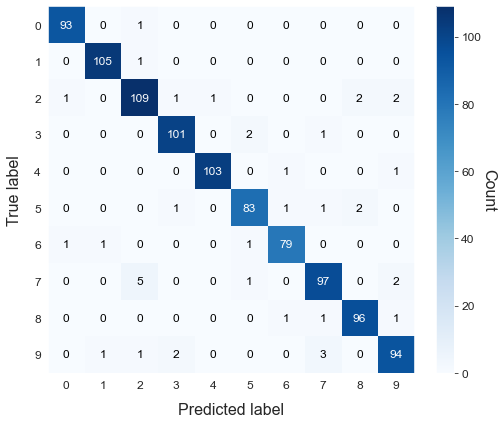

In [10]:
# Or make plots...
atom.nn.plot_confusion_matrix()